# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
!ls "/content/drive/My Drive/Data"

base_model.h5		       resnet_samplesize_model3.h5  vgg_1dropout_new.h5
densenet-100_sample.h5	       resnet_withaug_model2_.h5    vgg_20size.h5
densenet_2_dropout.h5	       test			    vgg_baseline.h5
densenet_img_aug.h5	       train			    vgg_imgaug_base.h5
model_cnn_noaug_70%.h5	       unique_20_sample_test	    vgg_imgaug.h5
model_weights_densenet_85%.h5  unique_20_sample_train	    vizgradcam
resnet_dropout_model1.h5       unique_5_sample_test	    xception_main1.h5
resnet_dropout_model2.h5       unique_5_sample_train	    xception_main.h5
resnet_samplesize_model1.h5    vgg_1dropout.h5


# Import Packages Required

In [3]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

# Get File Directory & Function

In [4]:
train_data_dir = "/content/drive/My Drive/Data/train"
test_data_dir = "/content/drive/My Drive/Data/test"

Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [5]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

# Preprocessing

In [6]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


In [7]:
img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# Mobilenet Set Up

In [8]:
baseModel = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = img_size + [3], weights='imagenet', include_top=False)
for layer in baseModel.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)

# 0 Dropout Layer

In [ ]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 256, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("mobilenet_base.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback, es],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1519s 2s/step - loss: 0.3193 - accuracy: 0.9017 - val_loss: 0.2514 - val_accuracy: 0.9076

Epoch 00001: val_accuracy improved from -inf to 0.90761, saving model to mobilenet_base.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
755/755 [==============================] - 210s 278ms/step - loss: 0.0569 - accuracy: 0.9433 - val_loss: 0.2260 - val_accuracy: 0.9371

Epoch 00002: val_accuracy improved from 0.90761 to 0.93711, saving model to mobilenet_base.h5
Epoch 3/25
755/755 [==============================] - 209s 277ms/step - loss: 0.0431 - accuracy: 0.9539 - val_loss: 0.1492 - val_accuracy: 0.9557

Epoch 00003: val_accuracy improved from 0.93711 to 0.95575, saving model to mobilenet_base.h5
Epoch 4/25
755/755 [==============================] - 209s 277ms/step - loss: 0.0314 - accuracy: 0.9665 - val_loss: 0.4055 - val_accuracy: 0.9278

Epoch 00004: val_accuracy did not improve from 0.95575
Epoch 5/25
755/755 [==============================] - 211s 279ms/step - loss: 0.0321 - accuracy: 0.9690 - val_loss: 0.1502 - val_accuracy: 0.9604

Epoch 00005: val_accuracy improved from 0.95575 to 0.96040, saving model to mobilenet_base.h5
Epoch 6/25
755/755 [==============================] - 211s 280ms/step - los

In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 46s 36ms/step - loss: 0.4904 - accuracy: 0.9666
Test Accuracy: 96.66%
755/755 [==============================] - 167s 221ms/step - loss: 0.0029 - accuracy: 0.9990
Train Accuracy: 99.90%


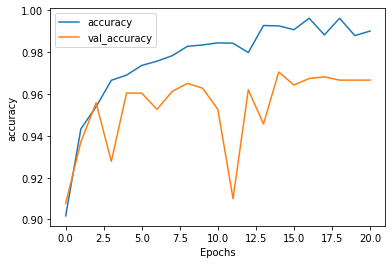

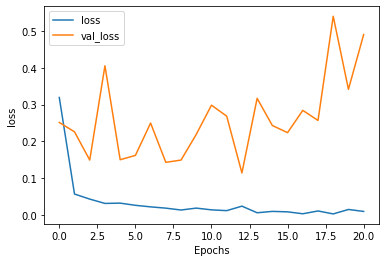

In [ ]:
plotting(history, "accuracy")
plotting(history, "loss")

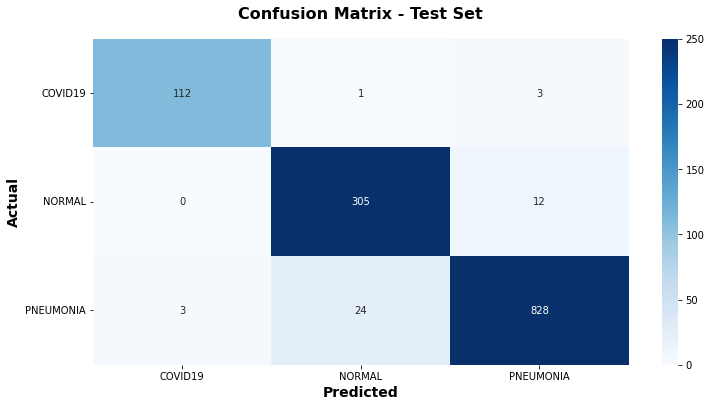

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 1 Dropout Layer

In [18]:
model_1 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_1 = Flatten()(model_1)

model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dropout(0.5)(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)
model_1 = Dense(units = 256, activation = 'relu')(model_1)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_1)
model_1 = Model(inputs = baseModel.input, outputs = predictions)
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [19]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_1.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [20]:
CheckPointCallback = ModelCheckpoint("mobilenet_dropout_1.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [21]:
seed(1)
tensorflow.random.set_seed(2)

history_1 = model_1.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback, es],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 4065s 5s/step - loss: 0.5748 - accuracy: 0.8341 - val_loss: 0.2218 - val_accuracy: 0.9239

Epoch 00001: val_accuracy improved from -inf to 0.92391, saving model to mobilenet_dropout_1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
755/755 [==============================] - 197s 261ms/step - loss: 0.1217 - accuracy: 0.8258 - val_loss: 0.4373 - val_accuracy: 0.7966

Epoch 00002: val_accuracy did not improve from 0.92391
Epoch 3/25
755/755 [==============================] - 197s 261ms/step - loss: 0.1240 - accuracy: 0.7988 - val_loss: 0.2801 - val_accuracy: 0.9309

Epoch 00003: val_accuracy improved from 0.92391 to 0.93090, saving model to mobilenet_dropout_1.h5
Epoch 4/25
755/755 [==============================] - 198s 262ms/step - loss: 0.0984 - accuracy: 0.8972 - val_loss: 0.1932 - val_accuracy: 0.9317

Epoch 00004: val_accuracy improved from 0.93090 to 0.93168, saving model to mobilenet_dropout_1.h5
Epoch 5/25
755/755 [==============================] - 199s 263ms/step - loss: 0.0985 - accuracy: 0.8921 - val_loss: 0.2829 - val_accuracy: 0.9317

Epoch 00005: val_accuracy did not improve from 0.93168
Epoch 6/25
755/755 [==============================] - 199s 263ms/step - loss: 0.0864 - accuracy: 0.9005 

In [22]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model_1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 45s 35ms/step - loss: 0.1630 - accuracy: 0.9557
Test Accuracy: 95.57%
755/755 [==============================] - 161s 213ms/step - loss: 0.1038 - accuracy: 0.9791
Train Accuracy: 97.91%


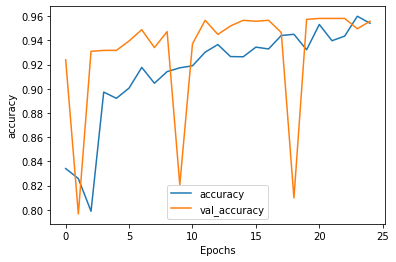

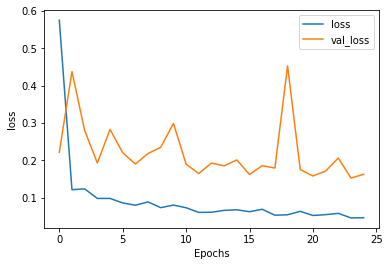

In [23]:
plotting(history_1, "accuracy")
plotting(history_1, "loss")

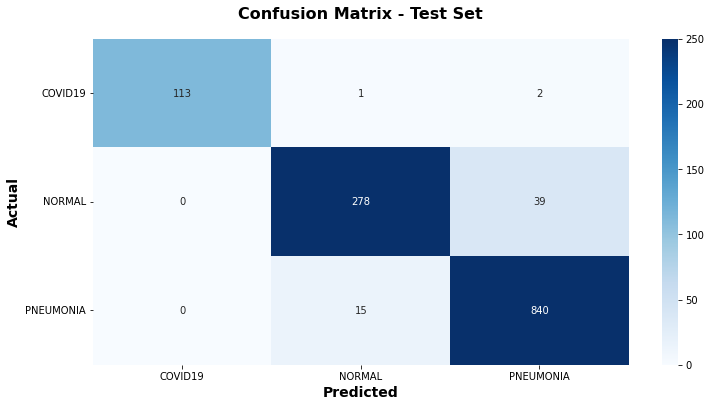

In [24]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
!git clone https://github.com/gkeechin/vizgradcam

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
os.chdir("/content/vizgradcam")

/content/vizgradcam/gradcam.py:77: RuntimeWarning: invalid value encountered in true_divide
  activation_map.max() - activation_map.min()


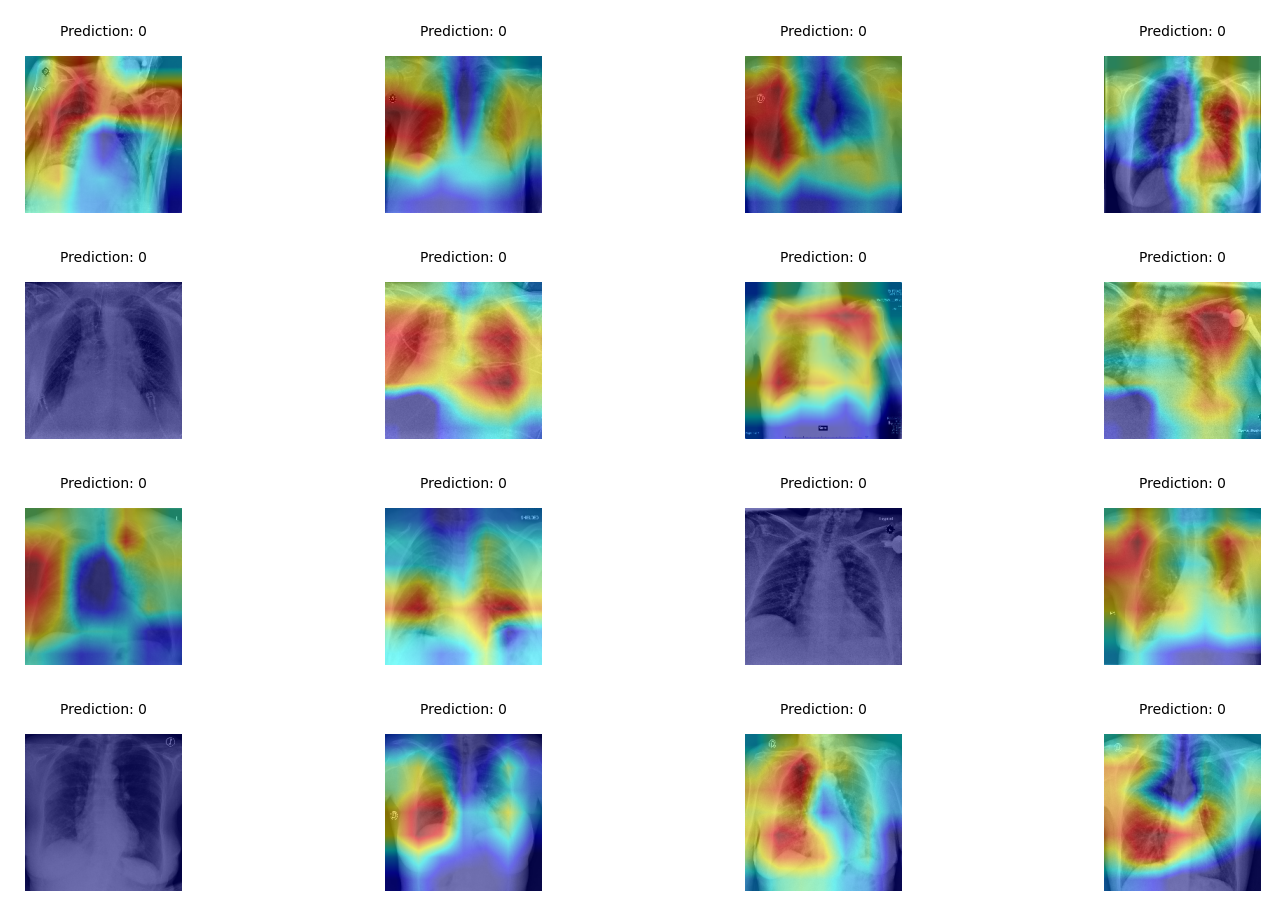

In [ ]:
from gradcam import VizGradCAM
for i in range(16):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  img = test_generator.__getitem__(i)
  preview_img, preview_labels = img
  pred = model_1.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model_1, preview_img[0])

# 2 Dropout Layers

In [25]:
model_2 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_2 = Flatten()(model_2)

model_2 = Dense(units = 256, activation = 'relu')(model_2)
model_2 = Dropout(0.2)(model_2)
model_2 = Dense(units = 256, activation = 'relu')(model_2)
model_2 = Dense(units = 256, activation = 'relu')(model_2)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_2)
model_2 = Model(inputs = baseModel.input, outputs = predictions)
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [26]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_2.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [27]:
CheckPointCallback = ModelCheckpoint("mobilenet_dropout_2.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [28]:
seed(1)
tensorflow.random.set_seed(2)

history_2 = model_2.fit(train_generator,
                    epochs = 20,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback, es],
                    verbose = 1)

Epoch 1/20
755/755 [==============================] - 207s 270ms/step - loss: 0.3735 - accuracy: 0.8737 - val_loss: 0.2656 - val_accuracy: 0.8991

Epoch 00001: val_accuracy improved from -inf to 0.89907, saving model to mobilenet_dropout_2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 199s 264ms/step - loss: 0.0813 - accuracy: 0.9112 - val_loss: 0.2749 - val_accuracy: 0.9239

Epoch 00002: val_accuracy improved from 0.89907 to 0.92391, saving model to mobilenet_dropout_2.h5
Epoch 3/20
755/755 [==============================] - 200s 264ms/step - loss: 0.0962 - accuracy: 0.9014 - val_loss: 0.2639 - val_accuracy: 0.9262

Epoch 00003: val_accuracy improved from 0.92391 to 0.92624, saving model to mobilenet_dropout_2.h5
Epoch 4/20
755/755 [==============================] - 203s 269ms/step - loss: 0.0721 - accuracy: 0.9136 - val_loss: 0.2279 - val_accuracy: 0.9084

Epoch 00004: val_accuracy did not improve from 0.92624
Epoch 5/20
755/755 [==============================] - 201s 267ms/step - loss: 0.0628 - accuracy: 0.9332 - val_loss: 0.1619 - val_accuracy: 0.9596

Epoch 00005: val_accuracy improved from 0.92624 to 0.95963, saving model to mobilenet_dropout_2.h5
Epoch 6/20
755/755 [==============================] - 201s 2

In [29]:
evaluation = model_2.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_2.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 43s 33ms/step - loss: 0.2020 - accuracy: 0.9534
Test Accuracy: 95.34%
755/755 [==============================] - 156s 206ms/step - loss: 0.0644 - accuracy: 0.9848
Train Accuracy: 98.48%


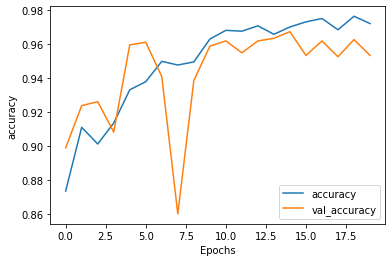

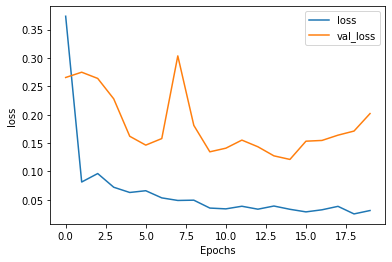

In [30]:
plotting(history_2, "accuracy")
plotting(history_2, "loss")

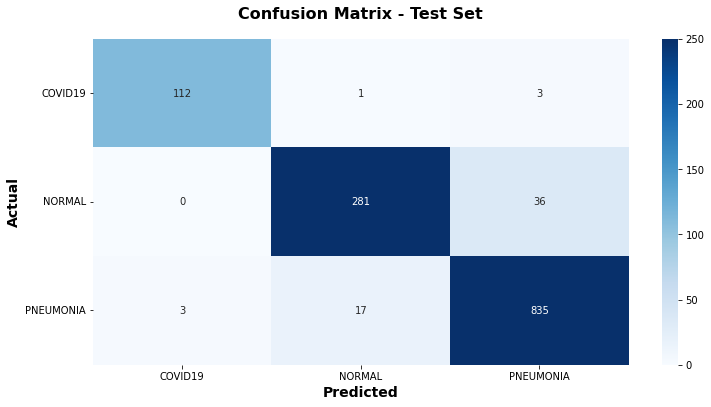

In [31]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_2.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 3 Dropout Layers

In [32]:
model_3 =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model_3 = Flatten()(model_3)

model_3 = Dense(units = 256, activation = 'relu')(model_3)
model_3 = Dropout(0.5)(model_3)
model_3 = Dense(units = 128, activation = 'relu')(model_3)
model_3 = Dense(units = 64, activation = 'relu')(model_3)

# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model_3)
model_3 = Model(inputs = baseModel.input, outputs = predictions)
model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [33]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model_3.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [34]:
CheckPointCallback = ModelCheckpoint("mobilenet_dropout_3.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [35]:
seed(1)
tensorflow.random.set_seed(2)

history_3 = model_3.fit(train_generator,
                    epochs = 20,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback, es],
                    verbose = 1)

Epoch 1/20
755/755 [==============================] - 201s 263ms/step - loss: 0.5892 - accuracy: 0.8112 - val_loss: 0.2943 - val_accuracy: 0.8820

Epoch 00001: val_accuracy improved from -inf to 0.88199, saving model to mobilenet_dropout_3.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 201s 266ms/step - loss: 0.1331 - accuracy: 0.8120 - val_loss: 0.2530 - val_accuracy: 0.9115

Epoch 00002: val_accuracy improved from 0.88199 to 0.91149, saving model to mobilenet_dropout_3.h5
Epoch 3/20
755/755 [==============================] - 198s 262ms/step - loss: 0.1159 - accuracy: 0.8024 - val_loss: 0.1977 - val_accuracy: 0.9309

Epoch 00003: val_accuracy improved from 0.91149 to 0.93090, saving model to mobilenet_dropout_3.h5
Epoch 4/20
755/755 [==============================] - 199s 264ms/step - loss: 0.1047 - accuracy: 0.8216 - val_loss: 0.1569 - val_accuracy: 0.9371

Epoch 00004: val_accuracy improved from 0.93090 to 0.93711, saving model to mobilenet_dropout_3.h5
Epoch 5/20
755/755 [==============================] - 200s 265ms/step - loss: 0.1342 - accuracy: 0.7663 - val_loss: 0.3235 - val_accuracy: 0.7601

Epoch 00005: val_accuracy did not improve from 0.93711
Epoch 6/20
755/755 [==============================] - 199s 2

In [36]:
evaluation = model_3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 44s 34ms/step - loss: 0.1668 - accuracy: 0.9464
Test Accuracy: 94.64%
755/755 [==============================] - 160s 211ms/step - loss: 0.1101 - accuracy: 0.9627
Train Accuracy: 96.27%


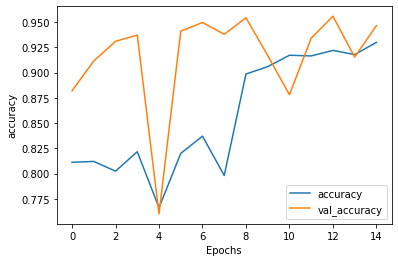

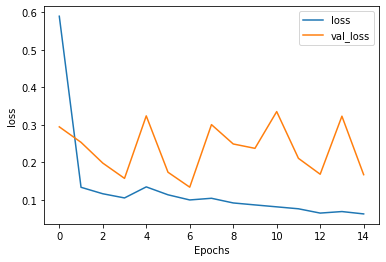

In [37]:
plotting(history_3, "accuracy")
plotting(history_3, "loss")

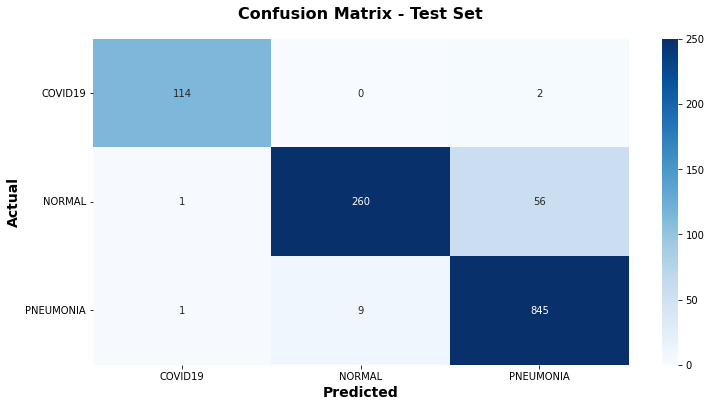

In [38]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model_3.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);